# Sequence Models

## Introduction
In this tutorial, you will learn about LSTM neural networks and see an example of how they can be used to recognize parts of speech.

In [1]:
import math
import os
import jdc
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from IPython.display import Image

torch.manual_seed(1)

In [2]:
# Get path to images directory
repo_dirpath = '/'.join(os.getcwd().split('/')[0:-1])
image_dirpath = os.path.join(repo_dirpath, 'images')

### What is an LSTM?
LSTM stands for Long Short-Term Memory. The network can learn sequences of information and make predictions based off of what it learns. It is a type of recurrent neural network. The LSTM cell has a state, which gets updated as the network trains. It is this state that allows the network to remember.

Here is a basic diagram of an LSTM:

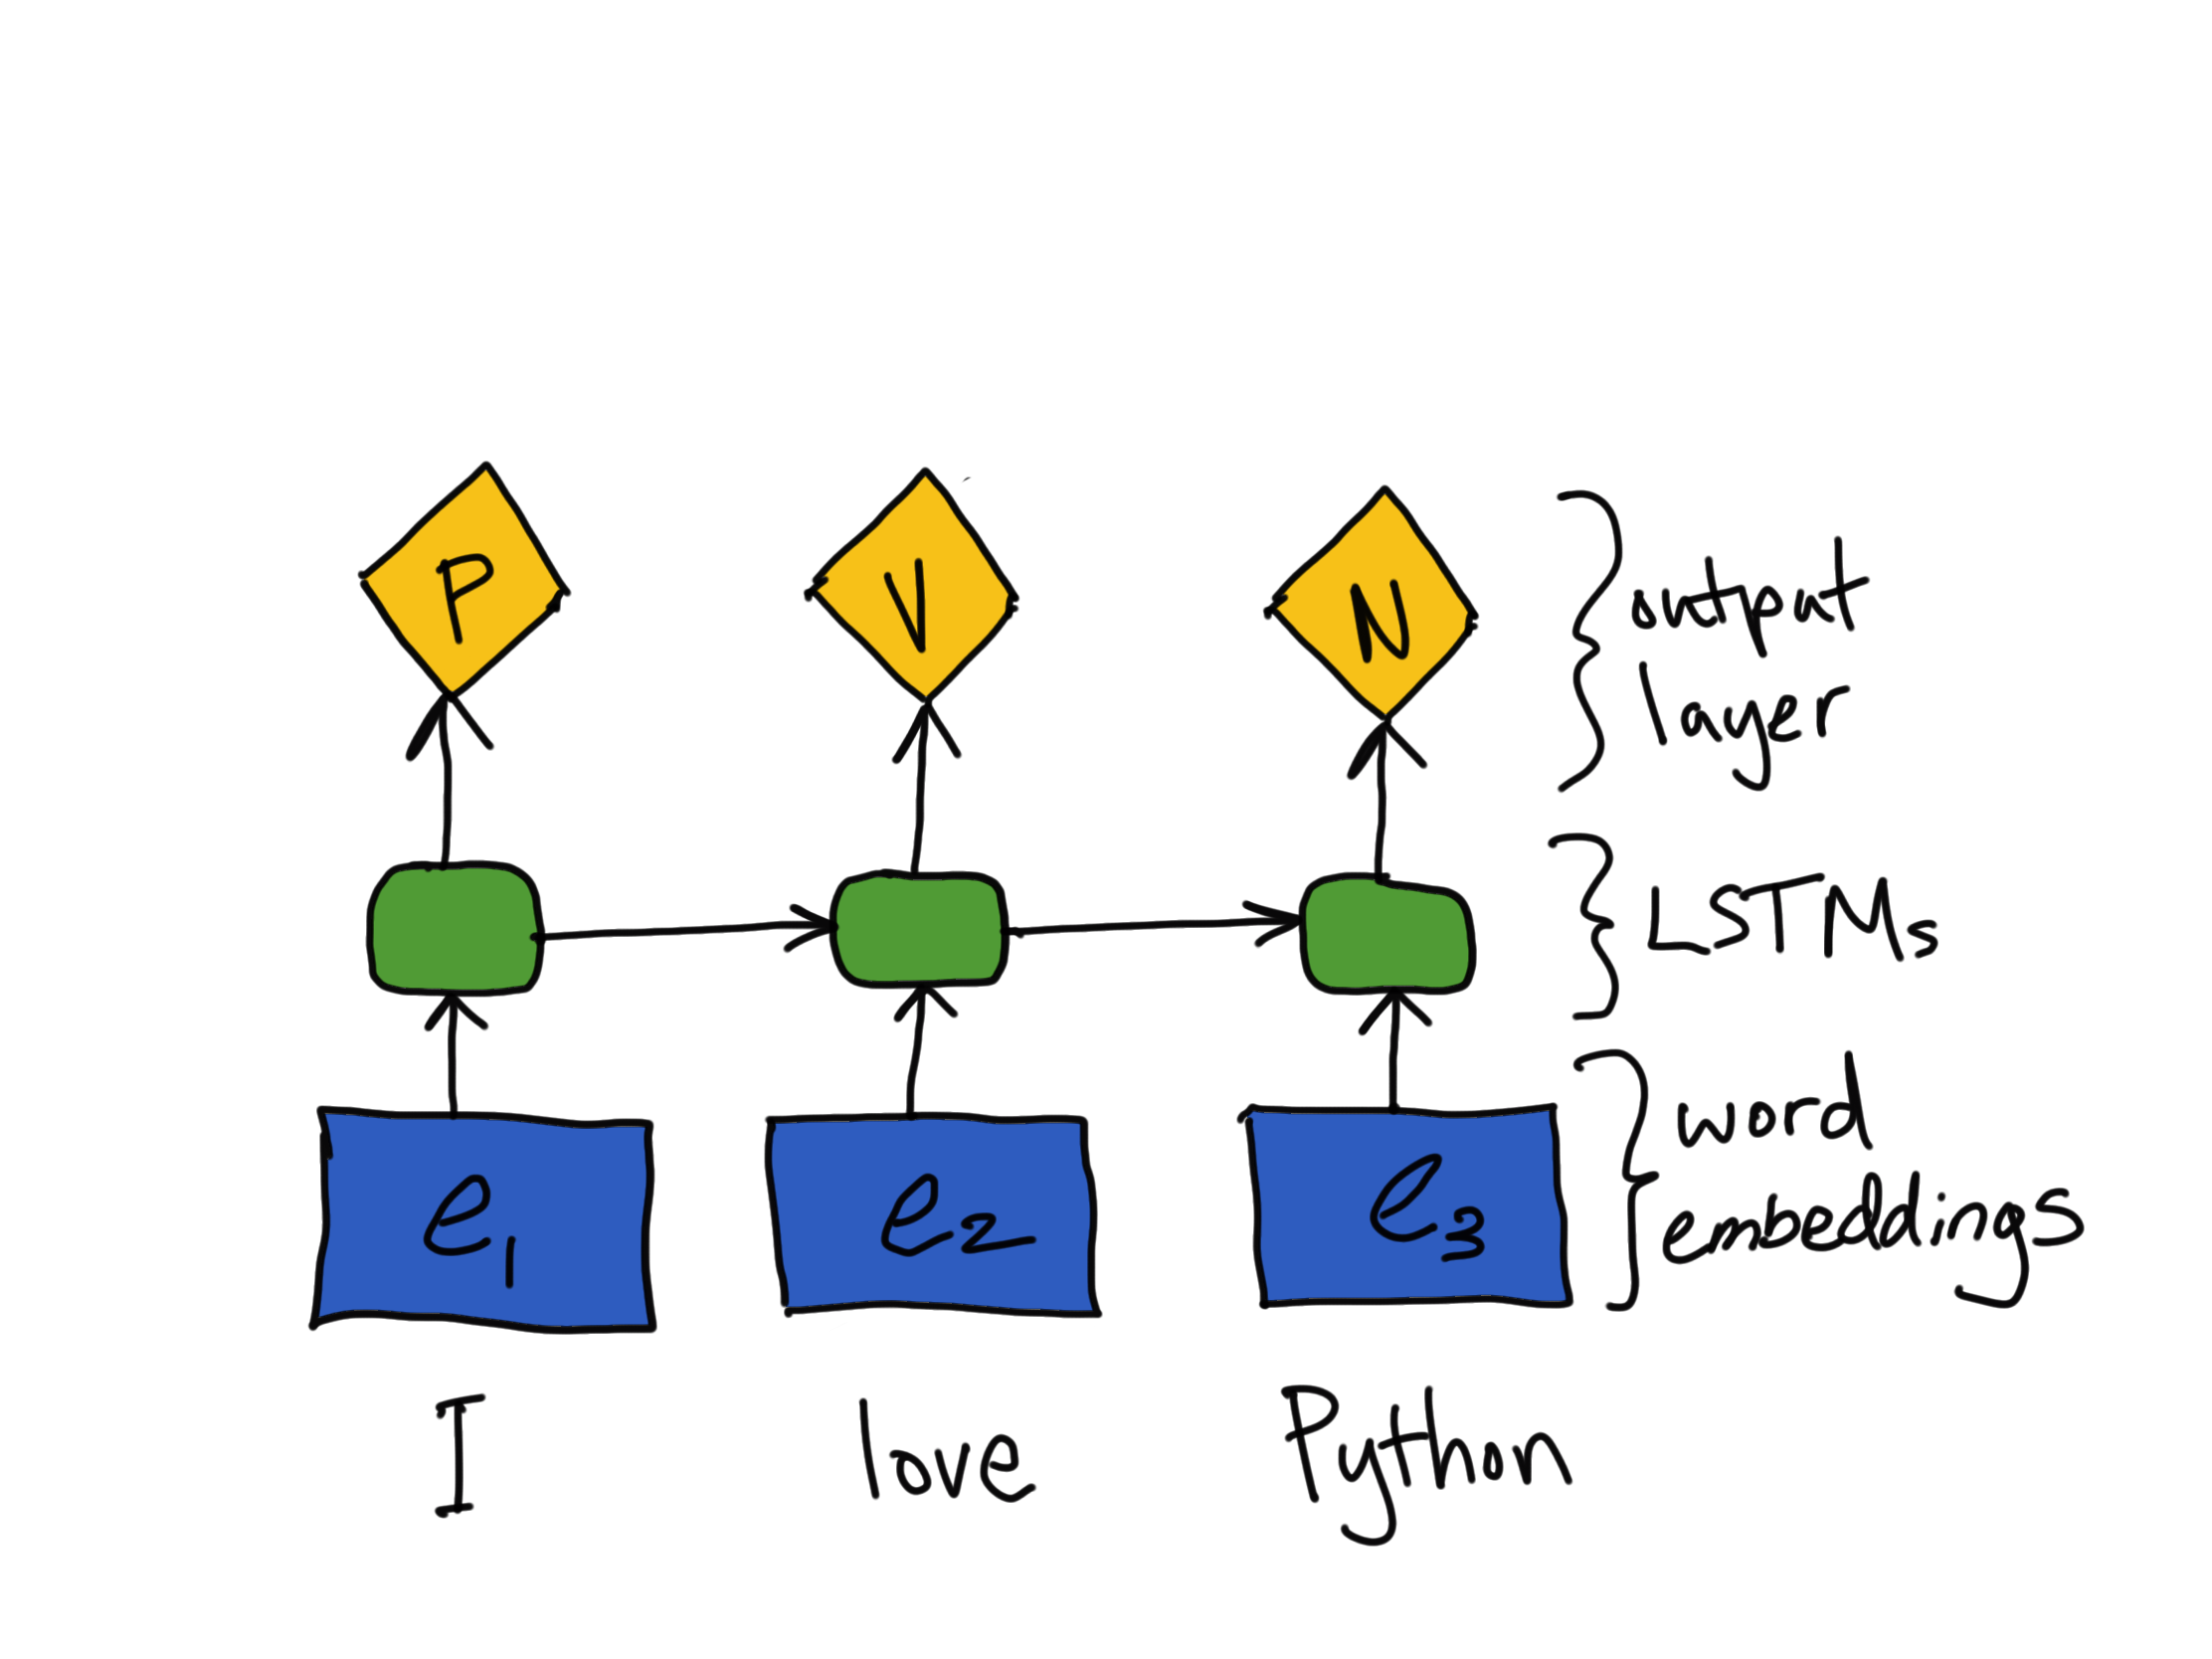

In [3]:
Image(filename=os.path.join(image_dirpath, 'lstm_flow.png'), width=500, height=500)

### LSTM Components
An LSTM cell consists of three gates. Each gate makes decisions on what information to pass on. The gates are:
* Forget Gate
* Input Gate
* Output Gate

#### Forget Gate
This gate decides what information is not important and removes it from the current LSTM state.

#### Input Gate.
The input gate decides what information to store in the current LSTM state.

#### Output Gate
Finally, the LSTM decides what information to output. This is done through the output gate.

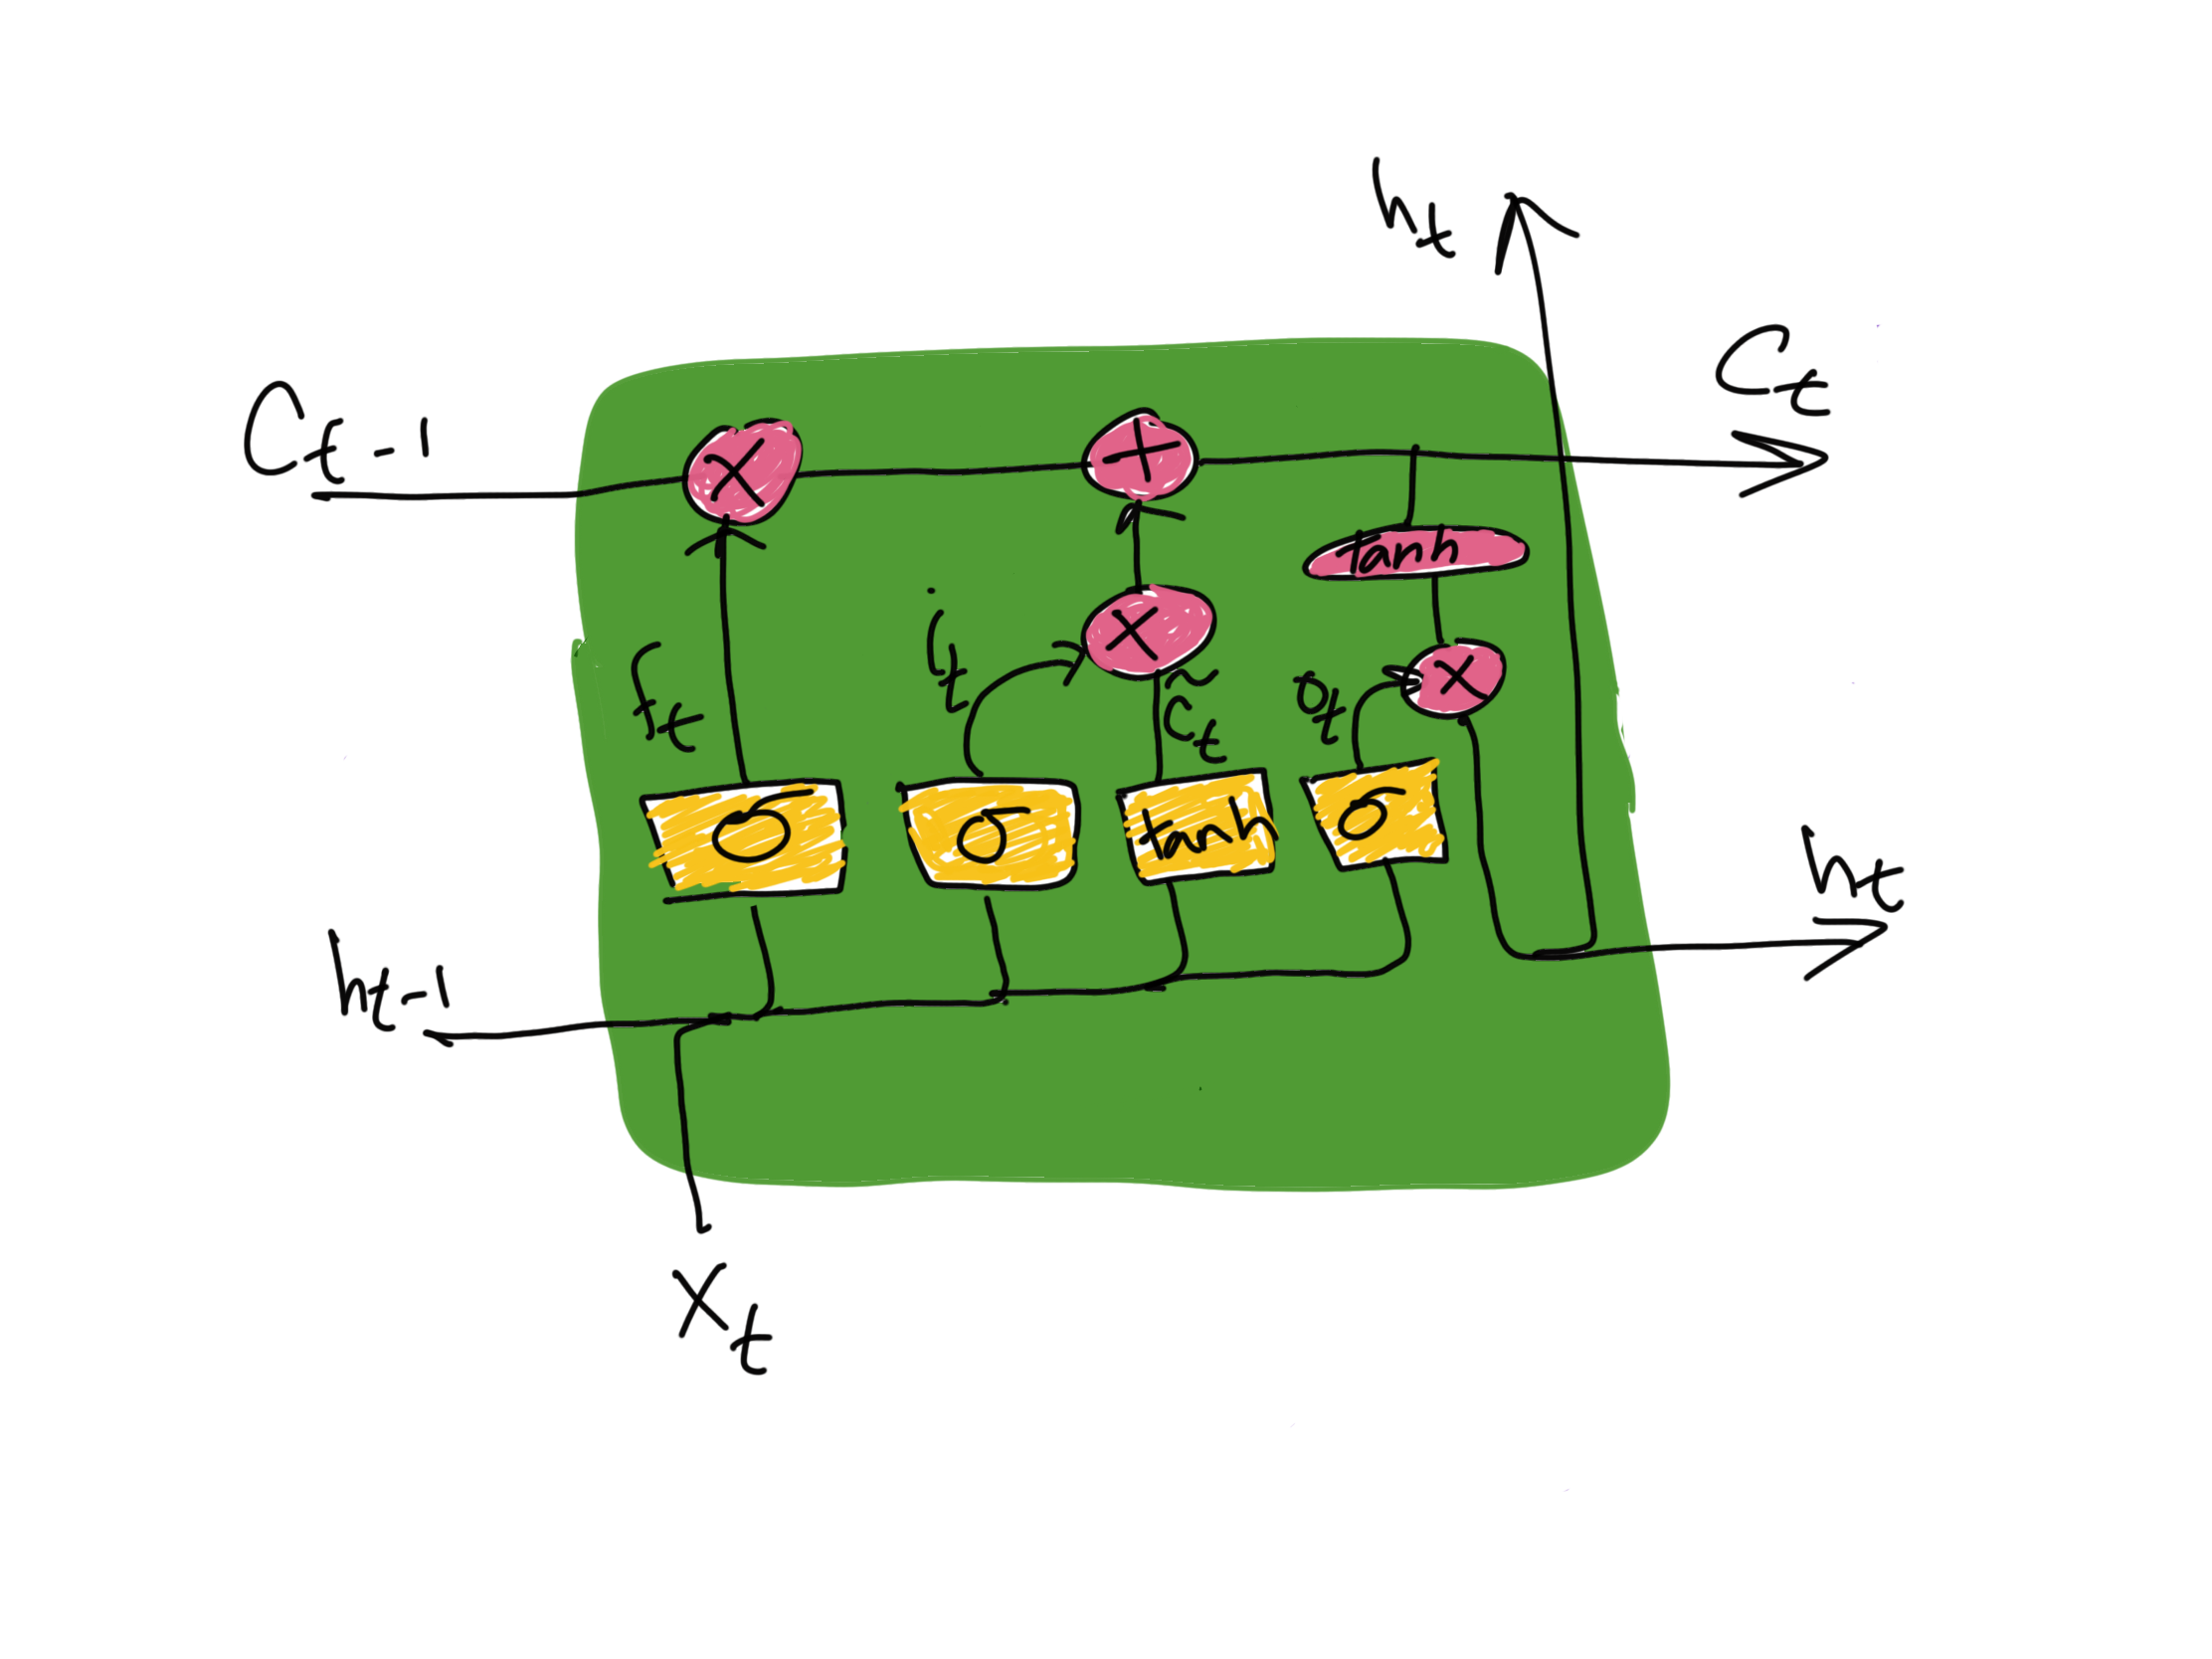

In [4]:
Image(filename=os.path.join(image_dirpath, 'lstm_inner_workings.png'), width=500, height=500)

### Very Simple Example 1
Before approaching the main example for this tutorial, let's see a very brief example of how to create and LSTM cell in Pytorch and pass information through it. One way to do this is using a **`for`** loop:

In [5]:
lstm = nn.LSTM(3, 3)  # Input dimension is 3, output dimension is 3
inputs = [torch.randn(1, 3) for _ in range(5)]  # Make a sequence of length 5

# Initialize the hidden state.
hidden = (torch.randn(1, 1, 3),
          torch.randn(1, 1, 3))
step = 1
for i in inputs:
    # Step through the sequence one element at a time.
    # After each time step, hidden contains the hidden state.
    out, hidden = lstm(i.view(1, 1, -1), hidden)
    print('Step {}:'.format(step))
    print(' - out: {}'.format(out))
    print(' - hidden: {}'.format(hidden))
    print('')
    step += 1

Step 1:
 - out: tensor([[[-0.2682,  0.0304, -0.1526]]])
 - hidden: (tensor([[[-0.2682,  0.0304, -0.1526]]]), tensor([[[-1.0766,  0.0972, -0.5498]]]))

Step 2:
 - out: tensor([[[-0.5370,  0.0346, -0.1958]]])
 - hidden: (tensor([[[-0.5370,  0.0346, -0.1958]]]), tensor([[[-1.1552,  0.1214, -0.2974]]]))

Step 3:
 - out: tensor([[[-0.3947,  0.0391, -0.1217]]])
 - hidden: (tensor([[[-0.3947,  0.0391, -0.1217]]]), tensor([[[-1.0727,  0.1104, -0.2179]]]))

Step 4:
 - out: tensor([[[-0.1854,  0.0740, -0.0979]]])
 - hidden: (tensor([[[-0.1854,  0.0740, -0.0979]]]), tensor([[[-1.0530,  0.1836, -0.1731]]]))

Step 5:
 - out: tensor([[[-0.3600,  0.0893,  0.0215]]])
 - hidden: (tensor([[[-0.3600,  0.0893,  0.0215]]]), tensor([[[-1.1298,  0.4467,  0.0254]]]))



### Very Simple Example 2
Instead of creating an LSTM using a **`for`** loop, we can use Pytorch's **`cat`** function to string together each layer of the LSTM.

In [6]:
lstm = nn.LSTM(3, 3)  # Input dimension is 3, output dimension is 3
inputs = [torch.randn(1, 3) for _ in range(5)]  # Make a sequence of length 5

inputs = torch.cat(inputs).view(len(inputs), 1, -1)
hidden = (torch.randn(1, 1, 3), torch.randn(1, 1, 3))  # Clean out hidden state
out, hidden = lstm(inputs, hidden)  # out = all states, hidden = last state and last cell state

In [7]:
print('all out states: {}'.format(out))
print('last hidden state: {}'.format(hidden))

all out states: tensor([[[-0.2696,  0.2599, -0.0758]],

        [[-0.4923,  0.1408, -0.0738]],

        [[-0.4523,  0.1241, -0.1461]],

        [[-0.3057,  0.1198, -0.0571]],

        [[-0.1077,  0.0289, -0.0487]]])
last hidden state: (tensor([[[-0.1077,  0.0289, -0.0487]]]), tensor([[[-0.1439,  0.1426, -0.2563]]]))


## Example: An LSTM for Part-of-Speech Tagging
In this example, a model will be created that can predict the part-of-speech for each word in a sentence. TODO: Show rolled out LSTM, labeling each word and part of speech.

### Prepare the data:
Let's begin by creating a dataset for training. The dataset will consist of a list of sequences. Each sequence will contain two lists. The first list is a sentence split up into words. The second list contains grammmer identifiers for each word in the sentence.

In [8]:
training_data = [
    ("The dog ate the apple.".split(), ["Determiner", "Noun", "Verb", "Determiner", "Noun"]),
    ("Everybody read that book.".split(), ["Noun", "Verb", "Determiner", "Noun"])
]
training_sentences = [training_data[x][0] for x in range(len(training_data))]

Since Pytorch only understands numbers, we need to map strings, such as the words in the training set, to integers. The following lines of code create a dictionary with this mapping:

In [9]:
word_to_ix = {}
for sentence, tags in training_data:
    for word in sentence:
        if word not in word_to_ix:
            word_to_ix[word] = len(word_to_ix)
print('word_to_ix: {}'.format(word_to_ix))

word_to_ix: {'Everybody': 5, 'that': 7, 'book.': 8, 'read': 6, 'dog': 1, 'the': 3, 'The': 0, 'apple.': 4, 'ate': 2}


We also need to map the parts-of-speech tags to integers:

In [10]:
# Tags to integers
tag_to_ix = {"Determiner": 0, "Noun": 1, "Verb": 2}

A third dictionary is used to map the integers back to parts-of-speech.

In [11]:
# Integers to tags
ix_to_tag = {0: "Determiner", 1: "Noun", 2: "Verb"}

### Set Hyperparameters

In [12]:
EMBEDDING_DIM = 6
HIDDEN_DIM = 6
LEARNING_RATE = 0.1
NUM_EPOCHS = 300

### Create the model
We will define the model by creating a Python class object. This class will inherit the nn.Module class from Pytorch, which will allow us to easily use the neural network classes defined in Pytorch.

The **`LSTMTagger`** class will take in four values, the embedding dimension, the number of hidden dimensions, the vocabulary size, and the size of the tag set.

In [13]:
class LSTMTagger(nn.Module):

    def __init__(self, embedding_dim, hidden_dim, vocab_size, tagset_size):
        super(LSTMTagger, self).__init__()
        self.hidden_dim = hidden_dim
        self.word_embeddings = nn.Embedding(vocab_size, embedding_dim)

        # LSTM: Inputs are embeddings, outputs are hidden states
        self.lstm = nn.LSTM(embedding_dim, hidden_dim)

        # Linear layer maps hidden space to tag space
        self.hidden2tag = nn.Linear(hidden_dim, tagset_size)
        self.hidden = self.init_hidden()

We will now create a function to initialize the hidden states.

In [14]:
%%add_to LSTMTagger
def init_hidden(self):
    """
    Initialize the hidden state. The axes correspond to (num_layers, minibatch_size, hidden_dim).
    """
    return (torch.zeros(1, 1, self.hidden_dim),
            torch.zeros(1, 1, self.hidden_dim))

Now we define a function to make a forward pass through the recurrent LSTM network. It will return the predict tag values given an input sentence.

In [15]:
%%add_to LSTMTagger
def forward(self, sentence):
    """
    Make a forward pass through the LSTM.
    
    :param sentence: The input sentence.
    :type sentence: list
    :return: A Tensor of tag scores.
    :rtype: Tensor
    """
    embeds = self.word_embeddings(sentence)
    lstm_out, self.hidden = self.lstm(
        embeds.view(len(sentence), 1, -1), self.hidden)
    tag_space = self.hidden2tag(lstm_out.view(len(sentence), -1))
    tag_scores = F.log_softmax(tag_space, dim=1)
    return tag_scores

### Helper Function
This helper function will be used to map either words or tags to integers, using the previously defined dictionaries (**`tag_to_ix`**, **`ix_to_tag`**).

In [16]:
def prepare_sequence(seq, to_ix):
    """
    Convert words or tags to intigers and return a Pytorch tensor.
    :param seq: Sequence of words.
    :type seq: list
    :param to_ix: Dictionary mapping words or tags to intigers.
    :return: A Pytorch tensor of indices.
    :rtype: Tensor
    """
    idxs = [to_ix[w] for w in seq]
    return torch.tensor(idxs, dtype=torch.long)

### Train the model:

Create the LSTM Pytorch model using the hyperparameters defined above.

In [17]:
model = LSTMTagger(EMBEDDING_DIM, HIDDEN_DIM, len(word_to_ix), len(tag_to_ix))

Define the loss function. In this case, we will be using a negative log likelihood function, which is useful in classification problems.

In [18]:
loss_function = nn.NLLLoss()

We can illustrate negative log likelihood in the following diagram:

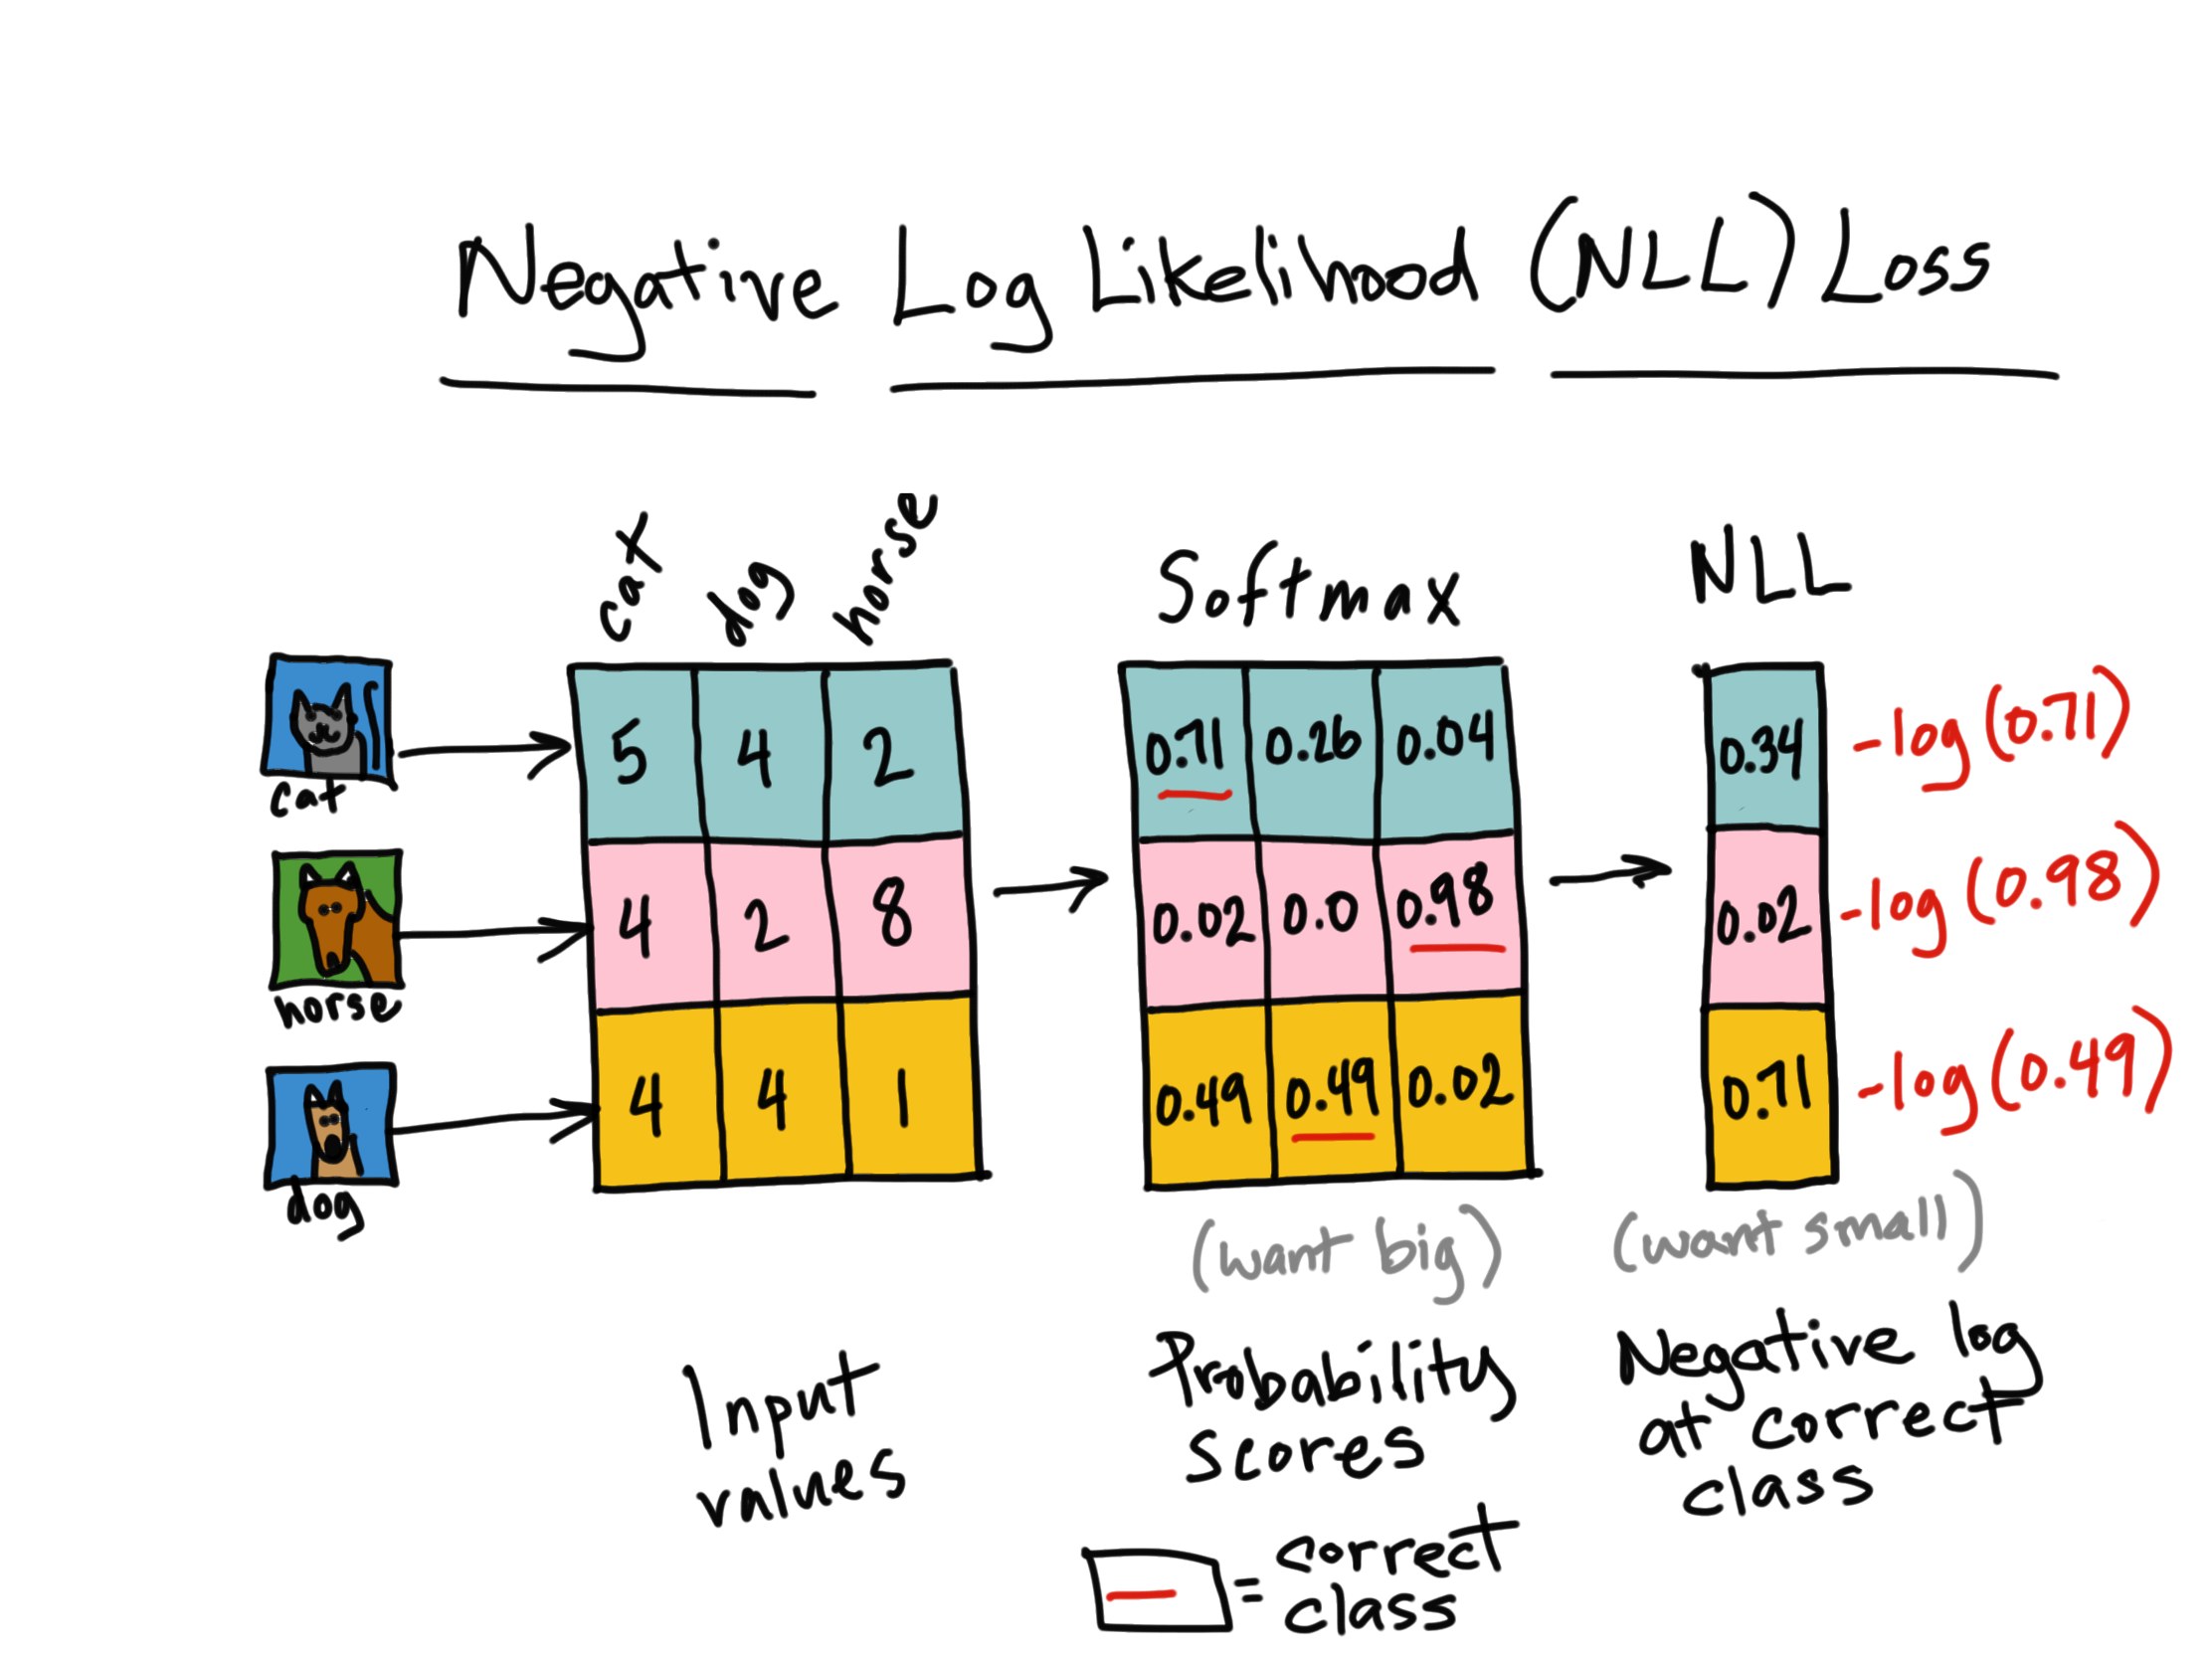

In [19]:
Image(filename=os.path.join(image_dirpath, 'nll_loss.png'), width=500, height=500)

We will train the model using stochastic gradient descent.

In [20]:
optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE)

Let's run the model before any training has been done and store the scores to a **`list`**. We will then compare these scores with the scores after training.

In [21]:
store_initial_probabilities = []
store_initial_predictions = []
with torch.no_grad():
    for sentence in training_sentences:
        inputs = prepare_sequence(sentence, word_to_ix)
        tag_scores = model(inputs)
        tag_probabilities = tag_scores.exp()
        max_values, max_indices = torch.max(tag_probabilities, 1)
        initial_prediction = [ix_to_tag[x] for x in max_indices.numpy()]
        store_initial_predictions.append(initial_prediction)
        store_initial_probabilities.append(tag_probabilities)

Now, we will train the model.

In [22]:
for epoch in range(NUM_EPOCHS):
    for sentence, tags in training_data:
        # Set gradients equal to zero after each intance
        model.zero_grad()
        
        # Initialize hidden state of LSTM after each intance
        model.hidden = model.init_hidden()
        
        # Turn inputs into tensors of word indices
        sentence_in = prepare_sequence(sentence, word_to_ix)
        targets = prepare_sequence(tags, tag_to_ix)
        
        # Run forward pass
        tag_scores = model(sentence_in)
        
        # Compute the loss, gradients, and update the parameters
        loss = loss_function(tag_scores, targets)
        loss.backward()
        optimizer.step()

Our model has now finished training. Let's print out some statistics to show how well the model training performed. 

In [23]:
# Print out the scores after training the model
store_initial_probabilities.reverse()
store_initial_predictions.reverse()
with torch.no_grad():
    for sentence in training_sentences:
        inputs = prepare_sequence(sentence, word_to_ix)
        tag_scores = model(inputs)
        tag_probabilities = tag_scores.exp()
        max_values, max_indices = torch.max(tag_probabilities, 1)
        predictions = [ix_to_tag[x] for x in max_indices.numpy()]
        
        print('Before training:')
        print(' - initial probabilities: {}'.format(store_initial_probabilities.pop()))
        print(' - sentence: {}'.format(' '.join(sentence)))
        print(' - prediction: {}'.format(store_initial_predictions.pop()))
        print('After training:')
        print(' - final probabilities: {}'.format(tag_probabilities))
        print(' - sentence: {}'.format(' '.join(sentence)))
        print(' - prediction: {}'.format(predictions))
        print('')

Before training:
 - initial probabilities: tensor([[ 0.3092,  0.3214,  0.3694],
        [ 0.3100,  0.3010,  0.3890],
        [ 0.2997,  0.3093,  0.3911],
        [ 0.3142,  0.3162,  0.3696],
        [ 0.3177,  0.3230,  0.3593]])
 - sentence: The dog ate the apple.
 - prediction: ['Verb', 'Verb', 'Verb', 'Verb', 'Verb']
After training:
 - final probabilities: tensor([[ 0.6940,  0.2731,  0.0329],
        [ 0.0701,  0.8339,  0.0961],
        [ 0.0581,  0.0236,  0.9183],
        [ 0.8283,  0.0406,  0.1312],
        [ 0.0109,  0.9855,  0.0036]])
 - sentence: The dog ate the apple.
 - prediction: ['Determiner', 'Noun', 'Verb', 'Determiner', 'Noun']

Before training:
 - initial probabilities: tensor([[ 0.3141,  0.3254,  0.3604],
        [ 0.3223,  0.3403,  0.3373],
        [ 0.3414,  0.3357,  0.3229],
        [ 0.3305,  0.3433,  0.3262]])
 - sentence: Everybody read that book.
 - prediction: ['Verb', 'Noun', 'Determiner', 'Noun']
After training:
 - final probabilities: tensor([[ 0.0056,  0.97

### What do the scores mean?
The scores are used to predict the parts-of-speech for each word in a sentence. A corresponding list of of possible parts-of-speech is assigned to each word. This list is the same for all data passed through the model. For example:

In [24]:
print('Let us take the sentence: {}'.format(' '.join(training_sentences[0])))
print('For the word "{}" the list of possible parts-of-speech are: {}'.format(training_sentences[0][0], [x for x in ix_to_tag.values()]))

Let us take the sentence: The dog ate the apple.
For the word "The" the list of possible parts-of-speech are: ['Determiner', 'Noun', 'Verb']


The model assigns a scores to each part-of-speech in the list. The prediction is then the part-of-speech with the highest score. If the model makes a correct prediction, then `Determiner` will have the highest score.

### Credits
This tutorial is closely based off of [Sequence Models and Long-Short Term Memory Networks](https://pytorch.org/tutorials/beginner/nlp/sequence_models_tutorial.html) tutorial on the Pytorch webpage. The original author is Robert Guthrie.